<a href="https://colab.research.google.com/github/xxvazquez/Food-and-Symptoms-Tracker/blob/main/Food_and_Symptoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meal and Symptom Correlation Analysis

This notebook analyzes the correlation between ingredients in meals and symptoms, identifying which ingredients are most frequently associated with symptoms within a specified time window after eating.

### Workflow:
1. **Google Sheets Authentication**: The notebook authenticates access to Google Sheets for loading meal and symptom data.
2. **Data Loading**: It loads the meal and symptom data from Google Sheets into pandas DataFrames.
3. **Symptom Time Windows**: It defines the time windows within which each symptom may occur after consuming a meal.
4. **Ingredient Extraction**: The ingredients from each meal are extracted and matched with corresponding symptoms based on the time window.
5. **Correlation Calculation**: The notebook counts how often each ingredient is associated with each symptom, then creates a correlation matrix.
6. **Visualization**: It visualizes the correlation matrix for the top 50 ingredients most correlated with symptoms using a heatmap.

### Key Features:
- **Time Window Matching**: The symptoms are matched with meals based on the defined time windows, ensuring a realistic correlation.
- **Ingredient-Symptom Correlation**: The frequency of symptom occurrences for each ingredient is calculated.
- **Visualization**: A heatmap is generated to visualize the strength of correlations between ingredients and symptoms.

### Notes:
- The meal and symptom data must be structured in Google Sheets with relevant columns for meal times, symptom times, and ingredient information.
- The script processes the top 50 ingredients most frequently correlated with symptoms, but this number can be adjusted as needed.


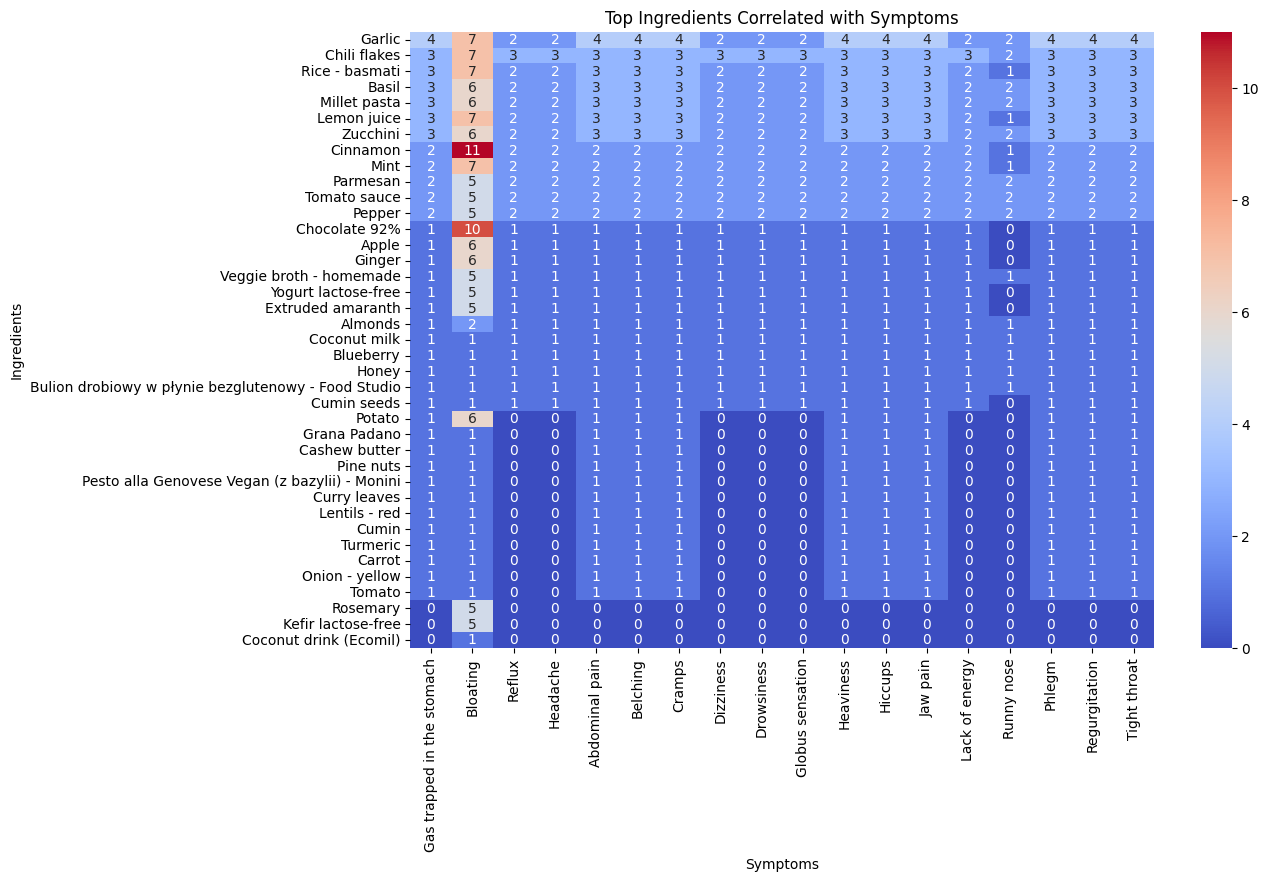

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
import gspread
from google.auth.transport.requests import Request
from google.auth import default
from datetime import timedelta

# Authenticate the user for Google Colab
auth.authenticate_user()

# Get credentials and authorize
creds, _ = default()
client = gspread.authorize(creds)

# Load Meal and Symptom Data from Google Sheets
# URLs for the meal and symptom data stored in Google Sheets
meal_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1440375433#gid=1440375433'
symptom_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1994524425#gid=1994524425'

# Open the worksheets by URL
meal_sheet = gc.open_by_url(meal_sheet_url).worksheet('Food')
symptom_sheet = gc.open_by_url(symptom_sheet_url).worksheet('Symptoms')

# Load the data into pandas DataFrames (structured tables)
meal_data = pd.DataFrame(meal_sheet.get_all_records())  # Meal data
symptom_data = pd.DataFrame(symptom_sheet.get_all_records())  # Symptom data

# Define symptom time windows (time range after a meal when symptoms may occur)
symptom_time_windows = {
    'Gas trapped in the stomach': timedelta(hours=4),
    'Bloating': timedelta(days=1),
    'Reflux': timedelta(hours=3),
    'Headache': timedelta(hours=3),
    'Abdominal pain': timedelta(hours=4),
    'Belching': timedelta(hours=4),
    'Cramps': timedelta(hours=4),
    'Dizziness': timedelta(hours=3),
    'Drowsiness': timedelta(hours=3),
    'Globus sensation': timedelta(hours=3),
    'Heaviness': timedelta(hours=4),
    'Hiccups': timedelta(hours=4),
    'Jaw pain': timedelta(hours=4),
    'Lack of energy': timedelta(hours=3),
    'Runny nose': timedelta(hours=2),
    'Phlegm': timedelta(hours=4),
    'Regurgitation': timedelta(hours=4),
    'Tight throat': timedelta(hours=4),
}

# Convert datetime columns to pandas datetime format for comparison
meal_data['Meal Date and Time'] = pd.to_datetime(meal_data['Meal Date and Time'])
symptom_data['Symptoms Date and Time'] = pd.to_datetime(symptom_data['Symptoms Date and Time'])

# Function to check if a symptom falls within the allowed time window after a meal
def is_within_time_window(meal_time, symptom_time, symptom_name):
    time_diff = symptom_time - meal_time  # Calculate the time difference between meal and symptom
    return abs(time_diff) <= symptom_time_windows[symptom_name]  # Return True if within window

# List of ingredient columns in the dataset
ingredient_columns = [
    'Dairy and subs', 'Fresh herbs and greens', 'Fruits', 'Grains',
    'Herbal and other drinks', 'Legumes', 'Nuts and seeds',
    'Powders, flours and other', 'Pre-made food', 'Spices', 'Vegetables'
]

# Initialize a dictionary to store the count of symptom occurrences for each ingredient
ingredient_symptom_correlations = {}

# Function to extract individual ingredients from each meal's data
def extract_ingredients(meal_row):
    ingredients = []  # List to store individual ingredients
    # Loop through all the ingredient columns
    for ingredient_column in ingredient_columns:
        if pd.notna(meal_row[ingredient_column]):  # Check if the ingredient cell is not empty
            ingredients_in_column = meal_row[ingredient_column].split(',')  # Split by commas (multiple ingredients)
            ingredients.extend([ingredient.strip() for ingredient in ingredients_in_column if ingredient.strip()])  # Clean and add
    return ingredients  # Return the list of individual ingredients

# Loop through each meal and symptom record to check for symptom correlations
for _, meal_row in meal_data.iterrows():
    meal_time = meal_row['Meal Date and Time']  # Get the meal time
    meal_ingredients = extract_ingredients(meal_row)  # Extract the list of ingredients from the meal
    # Loop through each symptom record to check if it's correlated with the meal
    for _, symptom_row in symptom_data.iterrows():
        symptom_time = symptom_row['Symptoms Date and Time']  # Get the symptom time

        # Check if the symptom falls within the time window of the meal
        for symptom_name in symptom_time_windows.keys():
            if is_within_time_window(meal_time, symptom_time, symptom_name):
                # Loop through each individual ingredient in the meal and record the correlation with the symptom
                for ingredient in meal_ingredients:
                    # If the ingredient is not already in the dictionary, add it with a zero count for each symptom
                    if ingredient not in ingredient_symptom_correlations:
                        ingredient_symptom_correlations[ingredient] = {symptom: 0 for symptom in symptom_time_windows.keys()}
                    ingredient_symptom_correlations[ingredient][symptom_name] += 1  # Increase the count for that symptom

# Calculate the total number of symptom occurrences for each ingredient
ingredient_total_counts = {ingredient: sum(symptom_correlations.values())
                           for ingredient, symptom_correlations in ingredient_symptom_correlations.items()}

# Sort ingredients by their total count (descending order) and select the top X
top_xx_ingredients = sorted(ingredient_total_counts, key=ingredient_total_counts.get, reverse=True)[:50]

# Prepare the new correlation matrix with only the top 20 ingredients
top_xx_correlation_matrix = []

for ingredient in top_xx_ingredients:
    symptom_correlations = ingredient_symptom_correlations[ingredient]
    row = [symptom_correlations[symptom] for symptom in symptom_time_windows.keys()]
    top_xx_correlation_matrix.append(row)

# Convert the list to a DataFrame for easier visualization
top_xx_correlation_df = pd.DataFrame(top_xx_correlation_matrix, columns=symptom_time_windows.keys(), index=top_xx_ingredients)

# Visualize the updated correlation matrix (heatmap)
plt.figure(figsize=(12, 8))  # Set figure size
sns.heatmap(top_xx_correlation_df, annot=True, cmap='coolwarm', cbar=True)  # Create heatmap with annotations
plt.title('Top Ingredients Correlated with Symptoms')  # Set title
plt.xlabel('Symptoms')  # Label the x-axis
plt.ylabel('Ingredients')  # Label the y-axis
plt.show()  # Show the heatmap


# Meal and Symptom Correlation Analysis with Severity Weighting

This notebook builds upon the previous analysis by incorporating severity scores for symptoms, normalizing them, and weighting the ingredient-symptom correlations based on the severity of symptoms.

### Key Updates:
- **Severity Weighting**: Symptoms are now weighted by their severity score, which is normalized to a range of 0 to 1.
- **Normalization**: The severity columns are normalized using `MinMaxScaler` to ensure that symptom severities are on a consistent scale.
- **Updated Correlation Matrix**: The correlation matrix now reflects the weighted symptom occurrences for each ingredient based on symptom severity.

### Notes:
- The severity data is normalized before calculating the correlations to ensure that more severe symptoms have a higher influence on the correlation results.
- The notebook visualizes the correlations for the top 20 ingredients most strongly associated with symptoms, factoring in their severity scores.


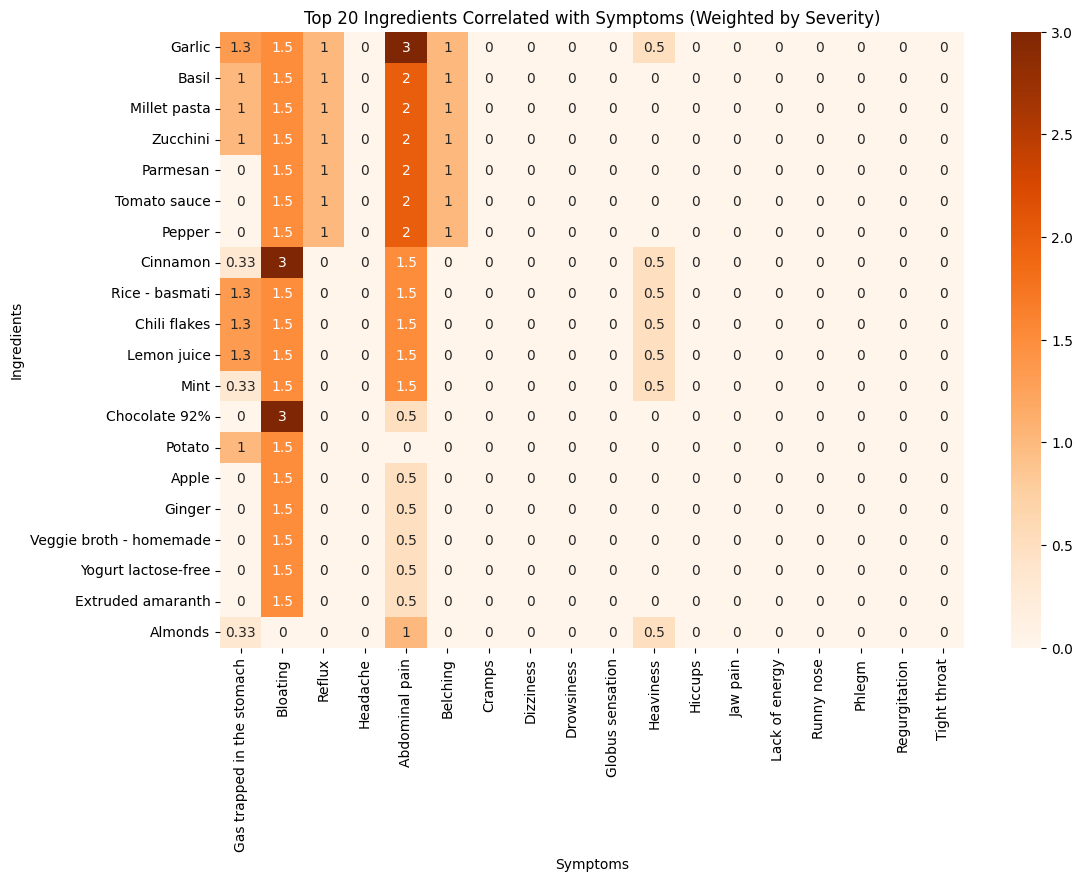

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
import gspread
from google.auth.transport.requests import Request
from google.auth import default
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# Google Sheets Authentication
auth.authenticate_user()  # Authenticate the user to access Google Sheets
creds, _ = default()  # Get default credentials
gc = gspread.authorize(creds)  # Authorize access to Google Sheets

# Load Meal and Symptom Data from Google Sheets
meal_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1440375433#gid=1440375433'
symptom_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1994524425#gid=1994524425'

# Open the worksheets by URL
meal_sheet = gc.open_by_url(meal_sheet_url).worksheet('Food')
symptom_sheet = gc.open_by_url(symptom_sheet_url).worksheet('Symptoms')

# Load the data into pandas DataFrames (structured tables)
meal_data = pd.DataFrame(meal_sheet.get_all_records())  # Meal data
symptom_data = pd.DataFrame(symptom_sheet.get_all_records())  # Symptom data

# Define symptom time windows (time range after a meal when symptoms may occur)
symptom_time_windows = {
    'Gas trapped in the stomach': timedelta(hours=4),
    'Bloating': timedelta(days=1),
    'Reflux': timedelta(hours=3),
    'Headache': timedelta(hours=3),
    'Abdominal pain': timedelta(hours=4),
    'Belching': timedelta(hours=4),
    'Cramps': timedelta(hours=4),
    'Dizziness': timedelta(hours=3),
    'Drowsiness': timedelta(hours=3),
    'Globus sensation': timedelta(hours=3),
    'Heaviness': timedelta(hours=4),
    'Hiccups': timedelta(hours=4),
    'Jaw pain': timedelta(hours=4),
    'Lack of energy': timedelta(hours=3),
    'Runny nose': timedelta(hours=2),
    'Phlegm': timedelta(hours=4),
    'Regurgitation': timedelta(hours=4),
    'Tight throat': timedelta(hours=4),
}

# Convert datetime columns to pandas datetime format for comparison
meal_data['Meal Date and Time'] = pd.to_datetime(meal_data['Meal Date and Time'])
symptom_data['Symptoms Date and Time'] = pd.to_datetime(symptom_data['Symptoms Date and Time'])

# Function to check if a symptom falls within the allowed time window after a meal
def is_within_time_window(meal_time, symptom_time, symptom_name):
    time_diff = symptom_time - meal_time  # Calculate the time difference between meal and symptom
    return abs(time_diff) <= symptom_time_windows[symptom_name]  # Return True if within window

# List of ingredient columns in the dataset
ingredient_columns = [
    'Dairy and subs', 'Fresh herbs and greens', 'Fruits', 'Grains',
    'Herbal and other drinks', 'Legumes', 'Nuts and seeds',
    'Powders, flours and other', 'Pre-made food', 'Spices', 'Vegetables'
]

# Initialize a dictionary to store the weighted count of symptom occurrences for each ingredient
ingredient_symptom_correlations = {}

# Function to extract individual ingredients from each meal's data
def extract_ingredients(meal_row):
    ingredients = []  # List to store individual ingredients
    # Loop through all the ingredient columns
    for ingredient_column in ingredient_columns:
        if pd.notna(meal_row[ingredient_column]):  # Check if the ingredient cell is not empty
            ingredients_in_column = meal_row[ingredient_column].split(',')  # Split by commas (multiple ingredients)
            ingredients.extend([ingredient.strip() for ingredient in ingredients_in_column if ingredient.strip()])  # Clean and add
    return ingredients  # Return the list of individual ingredients

# Normalize the severity scores (from 1 to 5) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalizing to a range of 0 to 1
severity_columns = [col for col in symptom_data.columns if col in symptom_time_windows.keys()]

# Convert the severity columns to numeric, forcing errors to NaN (invalid data is handled)
symptom_data[severity_columns] = symptom_data[severity_columns].apply(pd.to_numeric, errors='coerce')

# Now, fill NaN values with 0 or any other placeholder you prefer (e.g., fill with 0 for missing data)
symptom_data[severity_columns] = symptom_data[severity_columns].fillna(0)

# Apply normalization to severity columns (after handling missing/invalid data)
symptom_data[severity_columns] = scaler.fit_transform(symptom_data[severity_columns])

# Loop through each meal and symptom record to check for symptom correlations
for _, meal_row in meal_data.iterrows():
    meal_time = meal_row['Meal Date and Time']  # Get the meal time
    meal_ingredients = extract_ingredients(meal_row)  # Extract the list of ingredients from the meal
    # Loop through each symptom record to check if it's correlated with the meal
    for _, symptom_row in symptom_data.iterrows():
        symptom_time = symptom_row['Symptoms Date and Time']  # Get the symptom time

        # Check if the symptom falls within the time window of the meal
        for symptom_name in symptom_time_windows.keys():
            if is_within_time_window(meal_time, symptom_time, symptom_name):
                # Loop through each individual ingredient in the meal and record the correlation with the symptom
                for ingredient in meal_ingredients:
                    # If the ingredient is not already in the dictionary, add it with a zero count for each symptom
                    if ingredient not in ingredient_symptom_correlations:
                        ingredient_symptom_correlations[ingredient] = {symptom: 0 for symptom in symptom_time_windows.keys()}
                    # Increase the weighted count for the symptom (taking severity into account)
                    severity_score = symptom_row[symptom_name]  # Get the severity score (normalized)
                    ingredient_symptom_correlations[ingredient][symptom_name] += severity_score  # Weight by severity

# Calculate the total weighted symptom occurrences for each ingredient
ingredient_total_counts = {ingredient: sum(symptom_correlations.values())
                           for ingredient, symptom_correlations in ingredient_symptom_correlations.items()}

# Sort ingredients by their total weighted count (descending order) and select the top 20
top_20_ingredients = sorted(ingredient_total_counts, key=ingredient_total_counts.get, reverse=True)[:20]

# Prepare the new correlation matrix with only the top 20 ingredients
top_20_correlation_matrix = []

for ingredient in top_20_ingredients:
    symptom_correlations = ingredient_symptom_correlations[ingredient]
    row = [symptom_correlations[symptom] for symptom in symptom_time_windows.keys()]
    top_20_correlation_matrix.append(row)

# Convert the list to a DataFrame for easier visualization
top_20_correlation_df = pd.DataFrame(top_20_correlation_matrix, columns=symptom_time_windows.keys(), index=top_20_ingredients)

# Visualize the updated correlation matrix (heatmap)
plt.figure(figsize=(12, 8))  # Set figure size
sns.heatmap(top_20_correlation_df, annot=True, cmap='Oranges', cbar=True)  # Create heatmap with annotations
plt.title('Top 20 Ingredients Correlated with Symptoms (Weighted by Severity)')  # Set title
plt.xlabel('Symptoms')  # Label the x-axis
plt.ylabel('Ingredients')  # Label the y-axis
plt.show()  # Show the heatmap


# Safe Ingredient Meal Recommendation

This notebook recommends meals that contain ingredients associated with low symptom severity, which can help identify potentially safe meals based on symptom correlation.

### Key Updates:
- **Thresholding**: A severity threshold is defined to classify ingredients as "safe" based on their total weighted symptom correlation.
- **Safe Ingredients**: Ingredients with a total symptom severity below the threshold are considered safe.
- **Meal Recommendations**: Meals containing at least two safe ingredients are recommended for consumption.

### Process:
1. **Symptom Severity Calculation**: The severity of symptoms is weighted and used to determine the total correlation for each ingredient.
2. **Safe Ingredient Identification**: Ingredients with a low total symptom severity are identified as "safe."
3. **Meal Filtering**: Meals containing a sufficient number of safe ingredients are suggested.

This analysis provides meal recommendations based on safe ingredients that are less likely to cause discomfort.


In [186]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth.transport.requests import Request
from google.auth import default
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# Google Sheets Authentication
auth.authenticate_user()  # Authenticate the user to access Google Sheets
creds, _ = default()  # Get default credentials
gc = gspread.authorize(creds)  # Authorize access to Google Sheets

# Load Meal and Symptom Data from Google Sheets
meal_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1440375433#gid=1440375433'
symptom_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1994524425#gid=1994524425'

# Open the worksheets by URL
meal_sheet = gc.open_by_url(meal_sheet_url).worksheet('Food')
symptom_sheet = gc.open_by_url(symptom_sheet_url).worksheet('Symptoms')

# Load the data into pandas DataFrames (structured tables)
meal_data = pd.DataFrame(meal_sheet.get_all_records())  # Meal data
symptom_data = pd.DataFrame(symptom_sheet.get_all_records())  # Symptom data

# Define symptom time windows (time range after a meal when symptoms may occur)
symptom_time_windows = {
    'Gas trapped in the stomach': timedelta(hours=4),
    'Bloating': timedelta(days=1),
    'Reflux': timedelta(hours=3),
    'Headache': timedelta(hours=3),
    'Abdominal pain': timedelta(hours=4),
    'Belching': timedelta(hours=4),
    'Cramps': timedelta(hours=4),
    'Dizziness': timedelta(hours=3),
    'Drowsiness': timedelta(hours=3),
    'Globus sensation': timedelta(hours=3),
    'Heaviness': timedelta(hours=4),
    'Hiccups': timedelta(hours=4),
    'Jaw pain': timedelta(hours=4),
    'Lack of energy': timedelta(hours=3),
    'Runny nose': timedelta(hours=4),
    'Phlegm': timedelta(hours=4),
    'Regurgitation': timedelta(hours=4),
    'Tight throat': timedelta(hours=4),
}

# Convert datetime columns to pandas datetime format for comparison
meal_data['Meal Date and Time'] = pd.to_datetime(meal_data['Meal Date and Time'])
symptom_data['Symptoms Date and Time'] = pd.to_datetime(symptom_data['Symptoms Date and Time'])

# Function to check if a symptom falls within the allowed time window after a meal
def is_within_time_window(meal_time, symptom_time, symptom_name):
    time_diff = symptom_time - meal_time  # Calculate the time difference between meal and symptom
    return abs(time_diff) <= symptom_time_windows[symptom_name]  # Return True if within window

# List of ingredient columns in the dataset
ingredient_columns = [
    'Dairy and subs', 'Fresh herbs and greens', 'Fruits', 'Grains',
    'Herbal and other drinks', 'Legumes', 'Nuts and seeds',
    'Powders, flours and other', 'Pre-made food', 'Spices', 'Vegetables'
]

# Initialize a dictionary to store the weighted count of symptom occurrences for each ingredient
ingredient_symptom_correlations = {}

# Function to extract individual ingredients from each meal's data
def extract_ingredients(meal_row):
    ingredients = []  # List to store individual ingredients
    # Loop through all the ingredient columns
    for ingredient_column in ingredient_columns:
        if pd.notna(meal_row[ingredient_column]):  # Check if the ingredient cell is not empty
            ingredients_in_column = meal_row[ingredient_column].split(',')  # Split by commas (multiple ingredients)
            ingredients.extend([ingredient.strip() for ingredient in ingredients_in_column if ingredient.strip()])  # Clean and add
    return ingredients  # Return the list of individual ingredients

# Normalize the severity scores (from 1 to 5) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalizing to a range of 0 to 1
severity_columns = [col for col in symptom_data.columns if col in symptom_time_windows.keys()]

# Convert the severity columns to numeric, forcing errors to NaN (invalid data is handled)
symptom_data[severity_columns] = symptom_data[severity_columns].apply(pd.to_numeric, errors='coerce')

# Now, fill NaN values with 0 or any other placeholder you prefer (e.g., fill with 0 for missing data)
symptom_data[severity_columns] = symptom_data[severity_columns].fillna(0)

# Apply normalization to severity columns (after handling missing/invalid data)
symptom_data[severity_columns] = scaler.fit_transform(symptom_data[severity_columns])

# Loop through each meal and symptom record to check for symptom correlations
for _, meal_row in meal_data.iterrows():
    meal_time = meal_row['Meal Date and Time']  # Get the meal time
    meal_ingredients = extract_ingredients(meal_row)  # Extract the list of ingredients from the meal
    # Loop through each symptom record to check if it's correlated with the meal
    for _, symptom_row in symptom_data.iterrows():
        symptom_time = symptom_row['Symptoms Date and Time']  # Get the symptom time

        # Check if the symptom falls within the time window of the meal
        for symptom_name in symptom_time_windows.keys():
            if is_within_time_window(meal_time, symptom_time, symptom_name):
                # Loop through each individual ingredient in the meal and record the correlation with the symptom
                for ingredient in meal_ingredients:
                    # If the ingredient is not already in the dictionary, add it with a zero count for each symptom
                    if ingredient not in ingredient_symptom_correlations:
                        ingredient_symptom_correlations[ingredient] = {symptom: 0 for symptom in symptom_time_windows.keys()}
                    # Increase the weighted count for the symptom (taking severity into account)
                    severity_score = symptom_row[symptom_name]  # Get the severity score (normalized)
                    ingredient_symptom_correlations[ingredient][symptom_name] += severity_score  # Weight by severity

# Calculate the total weighted symptom occurrences for each ingredient
ingredient_total_counts = {ingredient: sum(symptom_correlations.values())
                           for ingredient, symptom_correlations in ingredient_symptom_correlations.items()}

# Sort ingredients by their total weighted count (descending order) and select the top 20
top_20_ingredients = sorted(ingredient_total_counts, key=ingredient_total_counts.get, reverse=True)[:100]

# Define a threshold for ingredient severity (optional: adjust this threshold based on your preference)
severity_threshold = 0.5  # You can adjust this value to be more or less strict in the recommendations

# Create a list to store ingredients that have lower symptom correlations
safe_ingredients = []

# Loop through the ingredient correlations
for ingredient, symptom_correlations in ingredient_symptom_correlations.items():
    total_symptom_severity = sum(symptom_correlations.values())

    # If the total severity is below the threshold, suggest this ingredient as safe
    if total_symptom_severity < severity_threshold:
        safe_ingredients.append(ingredient)

# Suggest meals containing safe ingredients
meal_recommendations = []

# Loop through each meal and suggest meals that contain safe ingredients
for _, meal_row in meal_data.iterrows():
    meal_ingredients = extract_ingredients(meal_row)  # Extract the list of ingredients from the meal
    # If the meal contains a significant number of safe ingredients, recommend it
    safe_ingredient_count = sum(1 for ingredient in meal_ingredients if ingredient in safe_ingredients)

    # If the meal has at least 2 safe ingredients (you can adjust this threshold)
    if safe_ingredient_count >= 2:
        meal_recommendations.append({
            'Meal Name': meal_row['Meal Name'],
            'Meal Type': meal_row['Meal type'],
            'Safe Ingredient Count': safe_ingredient_count,
            'Ingredients': ', '.join(meal_ingredients)
        })

# Create a DataFrame for easy visualization of the meal recommendations
meal_recommendations_df = pd.DataFrame(meal_recommendations)

# Display the meal recommendations
print(meal_recommendations_df)


Empty DataFrame
Columns: []
Index: []


# Sync Data from SQL to Google Sheets

This notebook is designed to automatically update the "Poopify backup" sheet in Google Sheets by extracting data from a backup SQL file, filtering out records that already exist, and adding only the new rows.

### Workflow:
1. **Google Drive Mount**: The notebook mounts your Google Drive to access files.
2. **Google Sheets Authentication**: It authenticates the user to read and write to Google Sheets.
3. **SQL Parsing**: The SQL backup file is parsed to extract relevant log data into a DataFrame.
4. **Filtering**: The notebook filters out existing records based on their `id` to avoid duplicating entries.
5. **Inserting New Data**: New rows are then added to the Google Sheet, and it prints the number of new rows added or a message saying "No rows to be added."

### Key Features:
- **Automatic Filtering**: It dynamically filters new rows that don't already exist in the Google Sheets by comparing `id` values.
- **Date Filtering**: Data is filtered by date, allowing for the inclusion of logs from a specific date onward.
- **Google Sheets Update**: It ensures that only the necessary new data is added to the Google Sheet.

### How It Works:
- It reads a `.sql` backup file stored in Google Drive.
- Parses SQL `INSERT` statements into a structured DataFrame.
- Compares the parsed data with existing records in Google Sheets.
- Adds only new records to avoid duplication.

### Notes:
- The script assumes that the Google Sheet is already set up with the same columns as the SQL log data.
- Make sure the sheet contains headers in the first row.


In [211]:
from google.colab import drive
import pandas as pd
import re
import gspread
from google.auth import default
from google.colab import auth

# Mount Google Drive to access files
drive.mount('/content/drive')

# Google Sheets Authentication
auth.authenticate_user()  # Authenticate the user to access Google Sheets
creds, _ = default()  # Get default credentials
gc = gspread.authorize(creds)  # Authorize access to Google Sheets

# Function to parse the SQL insert statements
def parse_sql_to_dataframe(sql_text):
    pattern = r"INSERT OR REPLACE INTO log\((.*?)\) VALUES \((.*?)\);"

    columns_25 = [
        'id', 'date', 'hour', 'day_of_week', 'color', 'consistency', 'smell',
        'has_blood', 'is_float', 'has_food', 'lat', 'long', 'volume', 'pain',
        'notes', 'flatulence', 'symptoms', 'f_i', 'time', 'strain', 'mucus',
        'profile', 'medication', 'consistency2', 'hygiene'
    ]

    columns_26 = [
        'id', 'date', 'hour', 'day_of_week', 'color', 'consistency', 'smell',
        'has_blood', 'is_float', 'has_food', 'lat', 'long', 'volume', 'pain',
        'notes', 'flatulence', 'symptoms', 'f_i', 'time', 'strain', 'mucus',
        'profile', 'medication', 'consistency2', 'hygiene', 'girth'
    ]

    rows = re.findall(pattern, sql_text)

    data = []
    for row in rows:
        values = [v if v != "NULL" else '' for v in re.findall(r"'(.*?)'|NULL", row[1])]
        values = [v if v != "NULL" else '' for v in values]

        if len(values) == len(columns_25):
            values.append('')
            values.append('')
        elif len(values) == len(columns_26):
            pass
        else:
            print(f"Skipping invalid row with length: {len(values)}")
            continue

        symptoms_index = len(columns_25) - 7
        if values[symptoms_index]:
            values[symptoms_index] = values[symptoms_index].split(';')

        mapped_values = dict(zip(columns_26, values))
        data.append(mapped_values)

    df = pd.DataFrame(data, columns=columns_26)

    # Convert 'date' column to string before inserting to Google Sheets
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

    df_filtered = df[df['date'] >= '2025-01-01']

    return df_filtered

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/Backups/poopify.sql'

# Read the SQL file as text
with open(file_path, 'r') as file:
    sql_text = file.read()

# Parse the SQL and filter the data
df_filtered = parse_sql_to_dataframe(sql_text)

# Open the Google Sheet by its URL
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1994524425#gid=1994524425')

# Select the 'Poopify' sheet
sheet = spreadsheet.worksheet("Poopify backup")

# Get existing IDs from the sheet
existing_ids = sheet.col_values(1)[1:]  # Skip the header row

# Filter out rows where the ID is already in the Google Sheet
new_data = df_filtered[~df_filtered['id'].isin(existing_ids)]

# Print the number of new rows that will be added
print(f"Number of new rows to be added: {len(new_data)}")

# Convert the new DataFrame to a list of lists
values_to_insert = new_data.values.tolist()

# Convert lists within cells (e.g., symptoms) to strings
for row in values_to_insert:
    for i, value in enumerate(row):
        if isinstance(value, list):
            row[i] = ', '.join(value)  # Convert lists into comma-separated strings

# Write the new data to the sheet, starting at the next available row
for i, row in enumerate(values_to_insert, start=len(existing_ids) + 2):
    sheet.insert_row(row, i)

if len(new_data) > 0:
    print(f"Number of new rows to be added: {len(new_data)}")
else:
    print("No rows to be added.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of new rows to be added: 0
No rows to be added


In [218]:
import pandas as pd
import gspread
from google.auth.transport.requests import Request
from google.auth import default

# Google Sheets Authentication
from google.colab import auth
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Poopify Backup sheet
poopify_backup_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=773954541#gid=773954541'
poopify_backup = gc.open_by_url(poopify_backup_url).worksheet('Poopify backup')

# Load the Poopify Backup data into pandas DataFrame
poopify_backup_data = pd.DataFrame(poopify_backup.get_all_records())

# Select the necessary columns and rename them
poopify_data = pd.DataFrame({
    'id': poopify_backup_data['id'],
    'date': pd.to_datetime(poopify_backup_data['date']).dt.strftime('%Y-%m-%d %H:%M:%S'),  # Convert to string
    'hour': poopify_backup_data['hour'],  # Hour is already just an integer (e.g., "8")
    'day of the week': pd.to_datetime(poopify_backup_data['date']).dt.strftime('%A'),  # Extract day of the week
    'consistency': poopify_backup_data['consistency'],
    'smell': poopify_backup_data['smell'],
    'floating': poopify_backup_data['is_float'],  # Rename as 'floating'
    'has food': poopify_backup_data['has_food'],
    'flatulence': poopify_backup_data['flatulence'],
    'symptoms': poopify_backup_data['symptoms'],
    'time': poopify_backup_data['time'],
    'strain': poopify_backup_data['strain'],
    'consistency2': poopify_backup_data['consistency2'],
    'hygiene': poopify_backup_data['hygiene']
})

# Clean the 'hygiene' column
def clean_hygiene(value):
    if value == 'water_and_soap' or value == 'cleaning_wipes_and_paper':
        return ''  # Set to empty
    elif value.startswith('dirty'):
        return value[-1]  # Extract the last character (0 or 3)
    return value  # Leave other values unchanged

# Apply the cleaning function to the 'hygiene' column
poopify_data['hygiene'] = poopify_data['hygiene'].apply(clean_hygiene)

# Open the Poopify sheet to write the data
poopify_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=927667407#gid=927667407'
poopify_sheet = gc.open_by_url(poopify_sheet_url).worksheet('Poopify')

# Get the existing 'id' values from the 'Poopify' sheet
existing_data = pd.DataFrame(poopify_sheet.get_all_records())
existing_ids = existing_data['id'].tolist() if 'id' in existing_data else []

# Filter the new data to only include rows where the 'id' is not already in the existing data
poopify_data_new = poopify_data[~poopify_data['id'].isin(existing_ids)]

# If there is any new data, write it to the 'Poopify' sheet
if not poopify_data_new.empty:
    poopify_sheet.update([poopify_data_new.columns.values.tolist()] + poopify_data_new.values.tolist())
    print(f"{len(poopify_data_new)} new rows added successfully!")
else:
    print("No new data to add.")


234 new rows added successfully!


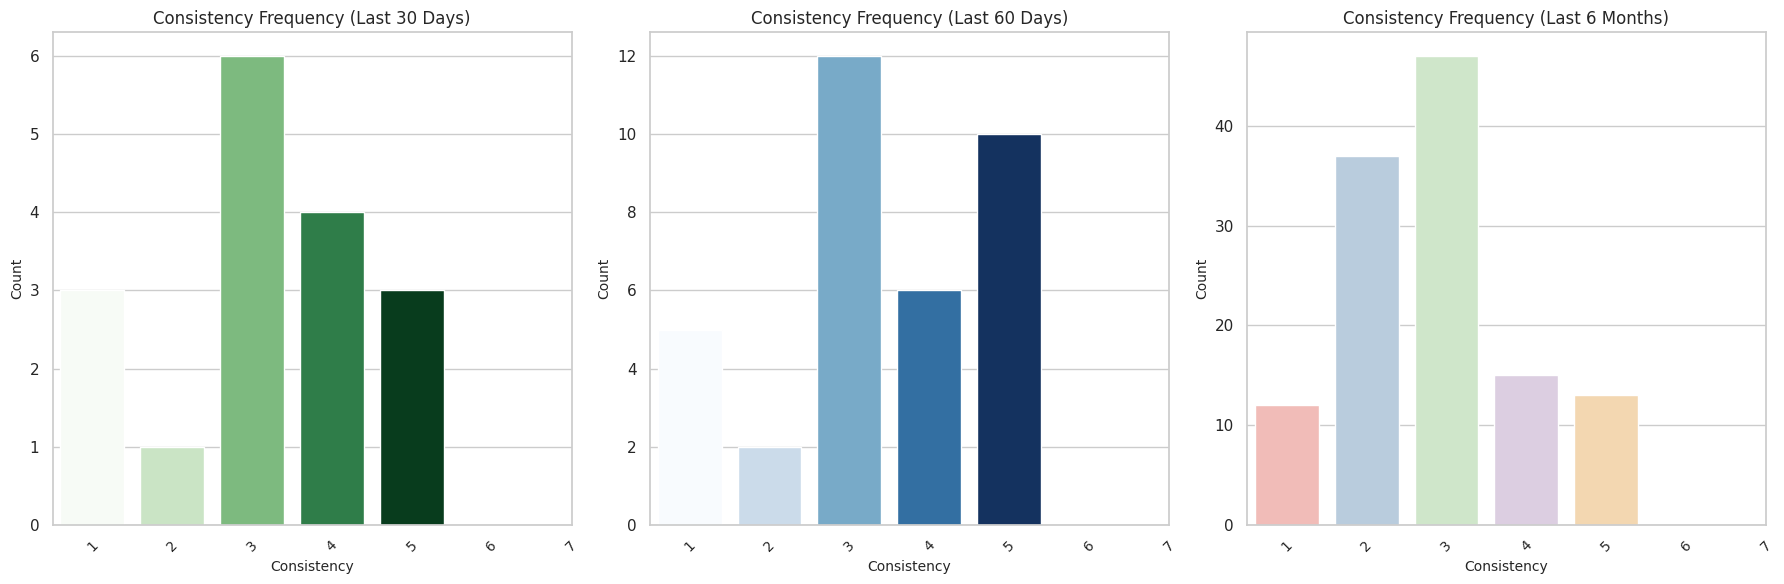

In [250]:
import pandas as pd
import gspread
from google.auth.transport.requests import Request
from google.auth import default
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Google Sheets Authentication
from google.colab import auth
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Poopify sheet
poopify_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=927667407#gid=927667407'
poopify_sheet = gc.open_by_url(poopify_sheet_url).worksheet('Poopify')

# Load the Poopify data into pandas DataFrame
poopify_data = pd.DataFrame(poopify_sheet.get_all_records())

# Convert 'date' column to datetime format
poopify_data['date'] = pd.to_datetime(poopify_data['date'])

# Filter out rows where consistency is 0 (no poop)
poopify_data = poopify_data[poopify_data['consistency'] != 0]

# Filter data for the last 30 days, 60 days, and 6 months
last_30_days = datetime.now() - timedelta(days=30)
last_60_days = datetime.now() - timedelta(days=60)
last_6_months = datetime.now() - timedelta(days=182)  # 6 months ≈ 182 days

# Filter for different periods
poopify_30_days = poopify_data[poopify_data['date'] >= last_30_days]
poopify_60_days = poopify_data[poopify_data['date'] >= last_60_days]
poopify_6_months = poopify_data[poopify_data['date'] >= last_6_months]

# Create the visualizations

# Create a figure with 1 row and 3 columns
plt.figure(figsize=(18, 6))  # Adjusted for side-by-side layout

# Last 30 days - Consistency Frequency
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
sns.countplot(x='consistency', data=poopify_30_days, palette='Greens', hue='consistency')
plt.legend([], frameon=False)  # Hide the legend
plt.title('Consistency Frequency (Last 30 Days)', fontsize=12)
plt.xlabel('Consistency', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=range(7), labels=[str(i) for i in range(1, 8)], rotation=45, fontsize=10)

# Last 60 days - Consistency Frequency
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
sns.countplot(x='consistency', data=poopify_60_days, palette='Blues', hue='consistency')
plt.legend([], frameon=False)  # Hide the legend
plt.title('Consistency Frequency (Last 60 Days)', fontsize=12)
plt.xlabel('Consistency', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=range(7), labels=[str(i) for i in range(1, 8)], rotation=45, fontsize=10)

# Last 6 months - Consistency Frequency
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
sns.countplot(x='consistency', data=poopify_6_months, palette='Pastel1', hue='consistency')
plt.legend([], frameon=False)  # Hide the legend
plt.title('Consistency Frequency (Last 6 Months)', fontsize=12)
plt.xlabel('Consistency', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=range(7), labels=[str(i) for i in range(1, 8)], rotation=45, fontsize=10)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


<ipython-input-278-2ddc4fe5d298>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=issue_proportion_df, x='Problematic Poop Proportion', y='Ingredient', palette='coolwarm')


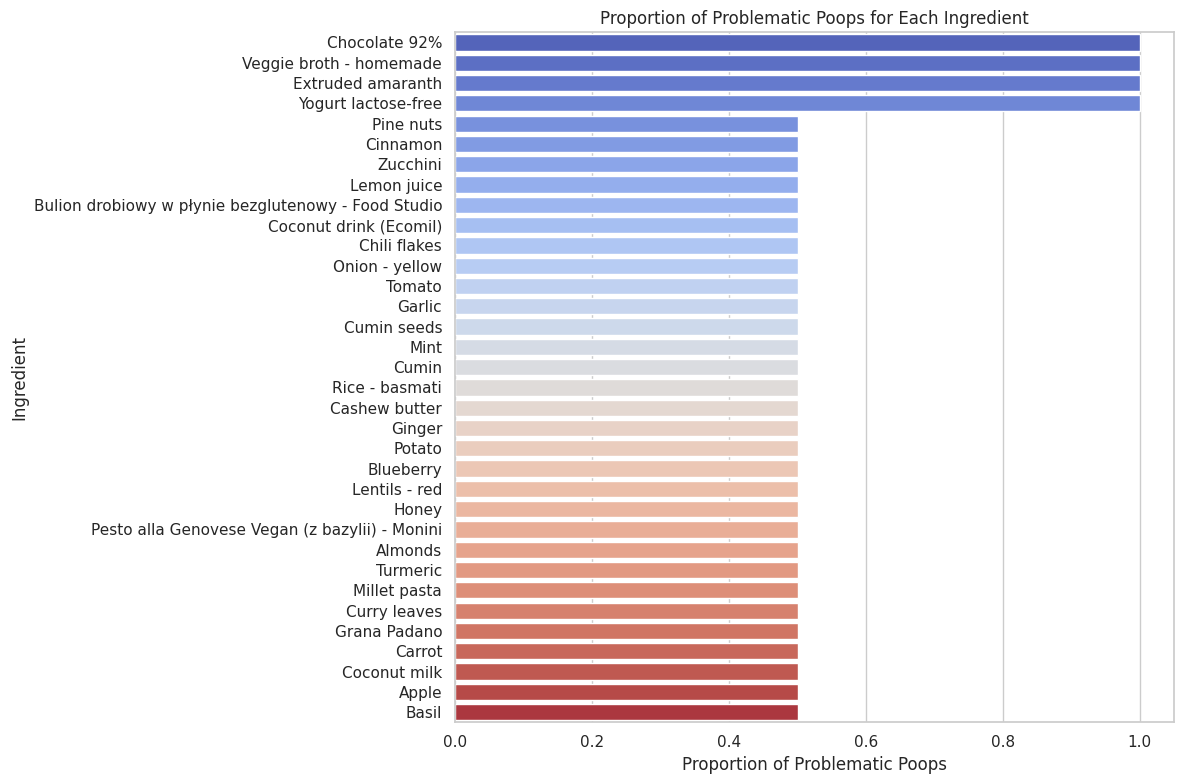

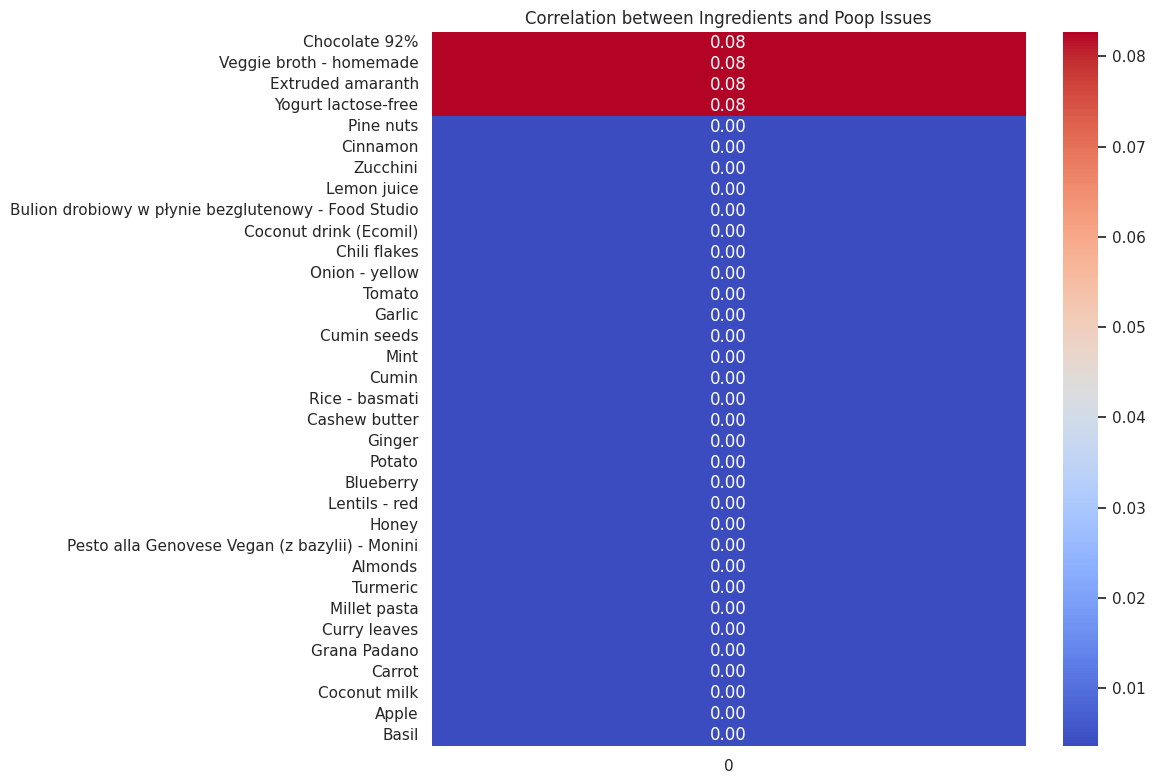

In [278]:
import pandas as pd
import gspread
from google.colab import auth
from google.auth.transport.requests import Request
from google.auth import default
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Authenticate the user for Google Colab
auth.authenticate_user()

# Get credentials and authorize
creds, _ = default()
client = gspread.authorize(creds)

# Load Meal and Poop Data from Google Sheets
meal_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1440375433#gid=1440375433'
poopify_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=2038328186#gid=2038328186'
stress_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=556357072#gid=556357072'

# Open the worksheets by URL
meal_sheet = client.open_by_url(meal_sheet_url).worksheet('Food')
poopify_sheet = client.open_by_url(poopify_sheet_url).worksheet('Poopify')
stress_sheet = client.open_by_url(stress_sheet_url).worksheet('Day and Night')

# Load the data into pandas DataFrames (structured tables)
meal_data = pd.DataFrame(meal_sheet.get_all_records())  # Meal data
poop_data = pd.DataFrame(poopify_sheet.get_all_records())  # Poop data
stress_data = pd.DataFrame(stress_sheet.get_all_records())  # Stress data

# Convert datetime columns to pandas datetime format for comparison
meal_data['Meal Date and Time'] = pd.to_datetime(meal_data['Meal Date and Time'], format='%d/%m/%Y %H:%M')
poop_data['date'] = pd.to_datetime(poop_data['date'], format='%Y-%m-%d %H:%M:%S')
stress_data['Submission Date'] = pd.to_datetime(stress_data['Submission Date'], format='%Y-%m-%d %H:%M:%S')

# List of ingredient columns in the dataset
ingredient_columns = [
    'Dairy and subs', 'Fresh herbs and greens', 'Fruits', 'Grains',
    'Herbal and other drinks', 'Legumes', 'Nuts and seeds',
    'Powders, flours and other', 'Pre-made food', 'Spices', 'Vegetables'
]

# Function to extract individual ingredients from each meal's data
def extract_ingredients(meal_row):
    ingredients = []  # List to store individual ingredients
    # Loop through all the ingredient columns
    for ingredient_column in ingredient_columns:
        if pd.notna(meal_row[ingredient_column]):  # Check if the ingredient cell is not empty
            ingredients_in_column = meal_row[ingredient_column].split(',')  # Split by commas (multiple ingredients)
            ingredients.extend([ingredient.strip() for ingredient in ingredients_in_column if ingredient.strip()])  # Clean and add
    return ingredients  # Return the list of individual ingredients

# Collect data for each poop record
poop_data_processed = []

for _, poop_row in poop_data.iterrows():
    poop_time = poop_row['date']  # Get the poop time
    poop_consistency = poop_row['consistency']  # Get the poop consistency value

    # Skip if the poop consistency is 0 (no poop)
    if poop_consistency == 0:
        continue

    # Get meals that occurred within the 3-day window before the poop time
    meals_in_window = meal_data[meal_data['Meal Date and Time'] <= poop_time]  # Get all meals before poop
    meals_in_window = meals_in_window[meals_in_window['Meal Date and Time'] >= poop_time - timedelta(days=3)]  # Only those in the window

    # Extract ingredients from the meals
    all_ingredients = []
    for _, meal_row in meals_in_window.iterrows():
        meal_ingredients = extract_ingredients(meal_row)
        all_ingredients.extend(meal_ingredients)  # Add all ingredients from the meal to the list

    # Create a new entry for the poop record with ingredients and consistency
    processed_entry = {'Poop Consistency': poop_consistency, 'Ingredients': all_ingredients}
    poop_data_processed.append(processed_entry)

# Convert processed data to DataFrame
processed_df = pd.DataFrame(poop_data_processed)

# Convert ingredients list to one-hot encoding
ingredients_list = [ingredient for sublist in processed_df['Ingredients'] for ingredient in sublist]
ingredients_unique = list(set(ingredients_list))  # Get unique ingredients

# Create a DataFrame for one-hot encoding of ingredients
one_hot_df = pd.DataFrame(0, index=processed_df.index, columns=ingredients_unique)
for idx, row in processed_df.iterrows():
    for ingredient in row['Ingredients']:
        one_hot_df.at[idx, ingredient] = 1

# Add Poop Consistency as a column to the one-hot DataFrame
one_hot_df['Poop Consistency'] = processed_df['Poop Consistency']

# Step 1: Label Poop Issues - anything not 3 or 4 is an issue
one_hot_df['Poop Issue'] = one_hot_df['Poop Consistency'].apply(lambda x: 1 if x != 3 and x != 4 else 0)

# Step 2: Calculate the proportion of problematic poops for each ingredient
ingredient_issue_proportion = []

for ingredient in one_hot_df.columns[:-2]:  # Exclude 'Poop Consistency' and 'Poop Issue' columns
    ingredient_data = one_hot_df[ingredient]
    problematic_poops = one_hot_df[ingredient_data == 1]['Poop Issue'].mean()  # Proportion of issue poops
    ingredient_issue_proportion.append((ingredient, problematic_poops))

# Create DataFrame for Ingredient Issue Proportions
issue_proportion_df = pd.DataFrame(ingredient_issue_proportion, columns=['Ingredient', 'Problematic Poop Proportion'])

# Sort ingredients by problematic poop proportion
issue_proportion_df = issue_proportion_df.sort_values(by='Problematic Poop Proportion', ascending=False)

# Step 3: Visualization - Bar chart of ingredients by problematic poop proportion
plt.figure(figsize=(12, 8))
sns.barplot(data=issue_proportion_df, x='Problematic Poop Proportion', y='Ingredient', palette='coolwarm')
plt.title('Proportion of Problematic Poops for Each Ingredient')
plt.xlabel('Proportion of Problematic Poops')
plt.ylabel('Ingredient')
plt.tight_layout()
plt.show()

# Step 4: Heatmap of correlation between ingredients and Poop Issue
# Create a correlation matrix (using Poop Issue as a binary target)
correlation_matrix = one_hot_df.drop(['Poop Consistency', 'Poop Issue'], axis=1).corrwith(one_hot_df['Poop Issue']).sort_values(ascending=False)

# Visualization: Heatmap of the correlation between ingredients and Poop Issues
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation between Ingredients and Poop Issues')
plt.tight_layout()
plt.show()



# Meal Time Distribution by Meal Type

This notebook visualizes the distribution of meal times for different meal types (Breakfast, Lunch, Dinner) using a boxplot.

### Key Steps:
1. **Data Extraction**: The meal data is retrieved from a Google Sheet, with the "Meal Date and Time" column parsed to a datetime format.
2. **Meal Time Calculation**: The meal time is extracted and converted to hours and minutes.
3. **Boxplot Visualization**: A seaborn boxplot is created to show the distribution of meal times, categorized by the type of meal (Breakfast, Lunch, Dinner).

The plot helps in identifying the typical meal times and variations for each meal type.


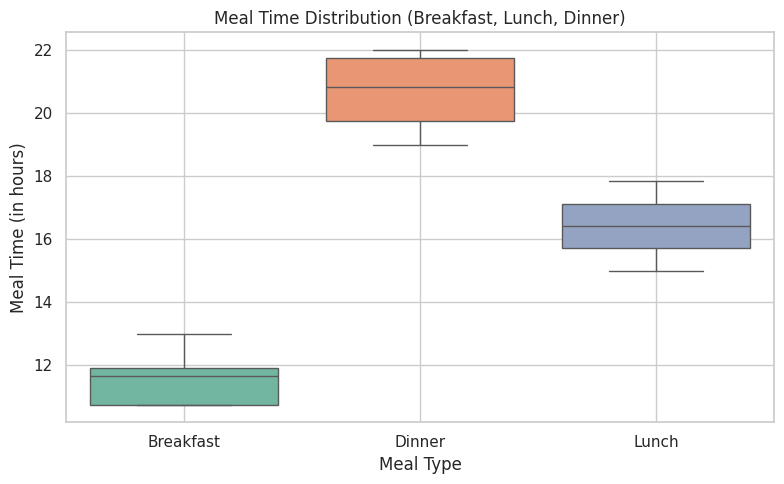

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import gspread
from google.auth.transport.requests import Request
from google.auth import default

# Google Sheets Authentication
auth.authenticate_user()  # Authenticate the user to access Google Sheets
creds, _ = default()  # Get default credentials
gc = gspread.authorize(creds)  # Authorize access to Google Sheets

# Meal Sheet URL
meal_sheet_url = 'https://docs.google.com/spreadsheets/d/1NUaTvo0sFL8ipS4nD56tigPI8X0buMePyrRJXHDj6_k/edit?gid=1440375433#gid=1440375433'

# Open the worksheet by URL
meal_sheet = gc.open_by_url(meal_sheet_url).worksheet('Food')

# Load the data into a pandas DataFrame
meal_data = pd.DataFrame(meal_sheet.get_all_records())

# Convert 'Meal Date and Time' to datetime
meal_data['Meal Date and Time'] = pd.to_datetime(meal_data['Meal Date and Time'], format='%d/%m/%Y %H:%M')

# Extract relevant columns
meal_data_clean = meal_data[['Meal Date and Time', 'Meal type']].dropna()

# Filter the data based on meal types (Breakfast, Lunch, Dinner)
meal_data_clean['Meal Time'] = meal_data_clean['Meal Date and Time'].dt.strftime('%H:%M')

# Set up a plot with seaborn for Boxplot, adding hue for 'Meal type'
plt.figure(figsize=(8, 5))
sns.boxplot(x='Meal type', y=meal_data_clean['Meal Date and Time'].dt.hour + meal_data_clean['Meal Date and Time'].dt.minute/60,
            data=meal_data_clean, hue='Meal type', palette='Set2', showfliers=False)

# Add labels and title
plt.xlabel('Meal Type')
plt.ylabel('Meal Time (in hours)')
plt.title('Meal Time Distribution (Breakfast, Lunch, Dinner)')

# Show grid
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
